In [2]:
import pandas as pd
import numpy as np
from random import randint
from scipy import stats
import random
import time
import re
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# Web-app visualizations
import plotly.express as px

# Data wrangling

In [3]:
df = pd.read_csv("data/centris_montreal_complete.csv")

In [4]:
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5732 entries, 0 to 5731
Data columns (total 101 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Unnamed: 0                               5732 non-null   int64  
 1   title                                    5732 non-null   object 
 2   address                                  5732 non-null   object 
 3   price                                    5732 non-null   object 
 4   lat                                      5732 non-null   float64
 5   long                                     5732 non-null   float64
 6   Restaurants                              5724 non-null   float64
 7   Shopping                                 5726 non-null   float64
 8   Vibrant                                  5724 non-null   float64
 9   Cycling friendly                         5723 non-null   float64
 10  Car friendly                             5721 n

We first remove the last 5 columns since they have virtually no content

In [5]:
df = df.loc[:,:"bedroom in basement"]

Next we will change the data type of the price column to integer

In [6]:
price_clean = df.price.str.replace("[$,]", "")
df.price = price_clean.astype("int")
df.price.describe()

count    5.732000e+03
mean     7.634336e+05
std      8.866054e+05
min      5.000000e+03
25%      3.999000e+05
50%      5.590000e+05
75%      8.242250e+05
max      2.780000e+07
Name: price, dtype: float64

## Duplicate data

We will use the `address` column to check for duplications.

In [7]:
df.address.duplicated().sum()

308

In [8]:
df = df[df.address.duplicated() == False]
df.reset_index(inplace=True)
df.info(max_cols=95)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5424 entries, 0 to 5423
Columns: 97 entries, index to bedroom in basement
dtypes: float64(32), int64(41), object(24)
memory usage: 4.0+ MB


Removing duplicates leaves holes in the index. Due to `reset_index()`, the range now coincides with the number of entries. 
The first two columns, corresponding to copies of the old and new index, can be removed.

In [9]:
df = df.loc[:, "title":]
df.columns

Index(['title', 'address', 'price', 'lat', 'long', 'Restaurants', 'Shopping',
       'Vibrant', 'Cycling friendly', 'Car friendly', 'Historic', 'Quiet',
       'Elementary Schools', 'High Schools', 'Parks', 'Nightlife', 'Groceries',
       'Daycares', 'Pedestrian friendly', 'Cafes', 'Transit friendly',
       'Greenery', 'rooms', 'bedrooms', 'bathroom', 'Condominium type',
       'Net area', 'Year built', 'Parking (total)', 'Population 2016 ',
       'Population variation between 2011 2016 ', 'Population density ',
       'Unemployment rate 2016 ', 'Less than $50,000 (%)',
       'Between $50,000 and $80,000 (%)', 'Between $80,000 and $100,000 (%)',
       'Between $100,000 and $150,000 (%)', 'More than $150,000 (%)',
       '1-person households (%)', '2-person households (%)',
       '3-person households (%)', '4-person households (%)',
       '5-person or more households (%)',
       'Couples without children at home (%)',
       'Couples with children at home (%)', 'Single-parent fa

## Room columns

There are two columns called `rooms` and `room`. We will inspect both to find an explenation for this.

In [10]:
df[df.room.notnull()].loc[:,["address", "room", "rooms"]].head()

,address,room,rooms
32,"4225, Rue Saint-Dominique, apt. 209, Montréal ...",1.0,NaN
95,"318Z - 330Z, Rue Sherbrooke Est, Montréal (Vil...",1.0,NaN
109,"1188, Rue Saint-Antoine Ouest, apt. P3-16-17, ...",1.0,NaN
142,"1000, Rue Ottawa, apt. 606, Montréal (Le Sud-O...",1.0,NaN
283,"6541, boulevard Saint-Laurent, apt. 201, Montr...",1.0,NaN


The room column corresponds to listings with with only a single room. This has been verified by visting the website and searching for some of the addresses. We will therefore merge the two columns.

In [11]:

print("Non-null values in 'rooms':")
print("Before merge -", df.rooms.notnull().sum())
# Merging "rooms" and "room"
rooms_new = pd.Series(\
    [room if pd.notna(room) else rooms for room, rooms in zip(df.room, df.rooms)]\
        )
# Remove old columns
df.drop(["rooms", "room"], axis=1, inplace=True)
# Add new column
df["rooms"] = rooms_new
print("After merge -", df.rooms.notnull().sum())

Non-null values in 'rooms':
Before merge - 4421
After merge - 4451


We will now incpect other columns that contain the string "room" and replace missing values by 0 to facilitate mathematical operations on room data. 

In [12]:
rooms = df.columns[["room" in col for col in df.columns]]
df[rooms] = df[rooms].fillna(0)
print(df[rooms].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5424 entries, 0 to 5423
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bedrooms              5424 non-null   float64
 1   bathroom              5424 non-null   float64
 2   bathrooms             5424 non-null   float64
 3   bedroom               5424 non-null   float64
 4   powder room           5424 non-null   float64
 5   powder rooms          5424 non-null   float64
 6   bedrooms in basement  5424 non-null   float64
 7   bedroom in basement   5424 non-null   float64
 8   rooms                 5424 non-null   float64
dtypes: float64(9)
memory usage: 381.5 KB
None


In [13]:
# Grouping similar columns
bedroom_cols = ['bedrooms','bedroom','bedrooms in basement', 'bedroom in basement']
bathroom_cols = ['bathroom', 'bathrooms']
powederroom_cols = ['powder room', 'powder rooms']

## Bedrooms

In [14]:
df[bedroom_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5424 entries, 0 to 5423
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bedrooms              5424 non-null   float64
 1   bedroom               5424 non-null   float64
 2   bedrooms in basement  5424 non-null   float64
 3   bedroom in basement   5424 non-null   float64
dtypes: float64(4)
memory usage: 169.6 KB


First, we merge `bedrooms` and `bedroom` since they clearly belong together

In [15]:
# Replace missing values with 0 for element-wise addition
bedrooms = df.bedrooms.fillna(0) + df.bedroom.fillna(0)
# Drop old columns from df
df.drop(["bedrooms", "bedroom"], axis=1)
# Add new column
df.bedrooms = bedrooms

In [16]:
# At least 1 bedroom in basement
df[df["bedrooms in basement"] > 0].\
    loc[:, ["address", "bedrooms", "bedrooms in basement", "bedroom in basement", "price"]].head()

,address,bedrooms,bedrooms in basement,bedroom in basement,price
151,"61A, Avenue Strathyre, Montréal (LaSalle)",0.0,2.0,0.0,259000
273,"1300, Rue Jarry Est, apt. 1, Montréal (Villera...",0.0,2.0,0.0,259000
353,"2061, Rue Beaudry, Montréal (Ville-Marie), Nei...",0.0,2.0,0.0,419000
627,"4723, Rue Ontario Est, apt. 102, Montréal (Mer...",0.0,2.0,0.0,259000
670,"7940, Rue Chabot, apt. 102, Montréal (Villeray...",0.0,2.0,0.0,379000


Bedrooms in the basement may be worth less, merging them with regular bedrooms may therefore not be optimal. However, the listings with bedrooms in the basement don't have regular bedrooms. This is true for for the entire list as well as for listings with a single bedroom in the basement. Merging all columns, therefore, appears to be the best solution. To keep a record of basement bedrooms, we will include a boolean column that can be used to either remove or alter corresponding entries at a later point.

In [17]:
def not_zero(col):
    """Returns boolean list indicating records with counts of at least 1"""

    not_zero = [count > 0 for count in col]
    return not_zero

In [18]:
# Merge of basement bedroom columns
basement_bed = df["bedrooms in basement"]\
         + df["bedroom in basement"]

# Records with basement bedrooms
basement_bed_bool = not_zero(basement_bed)
print("Apartments with basement bedrooms:",\
    sum(basement_bed_bool))

# Merge of basement with regular bedrooms
all_bedrooms = basement_bed + df.bedrooms
print("Apartments with any kind of bedroom",\
    sum(not_zero(all_bedrooms)))

Apartments with basement bedrooms: 75
Apartments with any kind of bedroom 4402


In [19]:
# Remove old columns 
df.drop(bedroom_cols, axis=1, inplace=True)

# Append new columns
df["bedrooms"] = all_bedrooms
df["basement_bedroom"] = basement_bed_bool

## Bathrooms

In [20]:
# Non-zero records
df[bathroom_cols].apply(lambda col: sum(not_zero(col)), axis=0)

bathroom     2465
bathrooms    1967
dtype: int64

In [21]:
# Merge
bathrooms = df.bathroom + df.bathrooms
print("Non-zero records of merged column:", sum(not_zero(bathrooms)))

# Remove old columns 
df.drop(bathroom_cols, axis=1, inplace=True)

# Append new column
df["bathrooms"] = bathrooms

Non-zero records of merged column: 4432


In [22]:
df.iloc[:, -4:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5424 entries, 0 to 5423
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rooms             5424 non-null   float64
 1   bedrooms          5424 non-null   float64
 2   basement_bedroom  5424 non-null   bool   
 3   bathrooms         5424 non-null   float64
dtypes: bool(1), float64(3)
memory usage: 132.5 KB


## Powder rooms

In [23]:
# Non-zero records
df[powederroom_cols].apply(lambda col: sum(not_zero(col)))

powder room     1086
powder rooms      81
dtype: int64

In [24]:
# Merge
powder_rooms = df['powder room'] + df['powder rooms']

# Remove old 
df.drop(powederroom_cols, axis=1, inplace=True)

# Append new
df['powder_rooms'] = powder_rooms

In [25]:
# New room data
room_data = df.iloc[:, [-5,-4,-2,-1]]

print("Non-zero records:")
room_data.apply(lambda col: sum(not_zero(col)))

Non-zero records:


rooms           4451
bedrooms        4402
bathrooms       4432
powder_rooms    1167
dtype: int64

## Missing Room Data

Next we will inspect records with missing data for all 4 room columns

In [26]:
# Records with 0 for all room features
# "not any(not_zero(rows))" is True, only if all records in a row are zero
missing_room_data = df[room_data.apply(lambda rows: (not any(not_zero(rows))), axis=1)]

print("Number of records with missing room data:", \
    missing_room_data.shape[0])
print("Number of replacable missing room data:", \
    missing_room_data.loc[:, "Main unit"].notnull().sum())

missing_room_data.iloc[:,[0, 1, 2,-5,-4,-2, -1]].head()

Number of records with missing room data: 973
Number of replacable missing room data: 868


,title,address,price,rooms,bedrooms,bathrooms,powder_rooms
9,Duplex for sale,"5421 - 5423, 15e Avenue, Montréal (Rosemont/La...",679000,0.0,0.0,0.0,0.0
10,Quadruplex for sale,"9636 - 9640, Rue Notre-Dame Est, Montréal (Mer...",569750,0.0,0.0,0.0,0.0
25,Duplex for sale,"1915 - 1917, Rue Viau, Montréal (Mercier/Hoche...",899000,0.0,0.0,0.0,0.0
29,Triplex for sale,"5518 - 5522, boulevard Saint-Michel, Montréal ...",719700,0.0,0.0,0.0,0.0
34,Triplex for sale,"6426 - 6428, Rue Marie-Victorin, Montréal (Mon...",599000,0.0,0.0,0.0,0.0


There are quite a lot of records with no room data in either of the 4 new columns that we just generated. 
The `Main unit` column is able to fill in most of the missing data.

In [27]:
missing_room_data["Main unit"].head()

9     6 rooms, 3 bedrooms, 2 bathrooms and 1 powder ...
10                       3 rooms, 1 bedroom, 1 bathroom
25                    11 rooms, 3 bedrooms, 2 bathrooms
29                      5 rooms, 2 bedrooms, 1 bathroom
34                      5 rooms, 3 bedrooms, 1 bathroom
Name: Main unit, dtype: object

From the above displayed records it seems most appropriate to split according to `","` and `"and"`

In [28]:
# Split room data in "Main unit"
main_split = df["Main unit"].str.split(", | and")
main_split

0                                     NaN
1                                     NaN
2                                     NaN
3                                     NaN
4                                     NaN
                      ...                
5419                                  NaN
5420                                  NaN
5421                                  NaN
5422    [4 rooms, 2 bedrooms, 1 bathroom]
5423                                  NaN
Name: Main unit, Length: 5424, dtype: object

In [29]:
def extract_rooms(room_list):
    """Turns the list into a DataFrame object, with text
    as column names and numbers as column values"""
    
    # Expected room types
    room_types = ["rooms", "room",\
        "bedrooms", "bedroom",\
        "bathrooms", "bathroom",\
        "powder rooms", "powder room"]

    # No room data
    if room_list is np.nan:
        return pd.Series([0,0,0,0,0,0,0,0],\
            index=room_types)

    # Result table   
    room_data = pd.Series()

    # Extract and append room data
    for string in room_list:
        number_of_rooms = re.search("\d+", string).group()
        room_type = re.search("[a-z]+\D*", string).group()
        room_data[room_type] = number_of_rooms
    
    
    # Add missing room types with value 0
    for room_type in room_types:
        if room_type not in room_data.index:
            room_data[room_type] = 0

    # Consistent column order
    return room_data[room_types]

In [30]:
# Extract data from "Main unit"
missing_room_data = main_split.\
    apply(lambda rows: extract_rooms(rows)).\
        astype('int')
missing_room_data

/home/jahnic/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



,rooms,room,bedrooms,bedroom,bathrooms,bathroom,powder rooms,powder room
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
5419,0,0,0,0,0,0,0,0
5420,0,0,0,0,0,0,0,0
5421,0,0,0,0,0,0,0,0
5422,4,0,2,0,0,1,0,0


In [31]:
# Merge related columns
rooms = missing_room_data.rooms + missing_room_data.room
bedrooms = missing_room_data.bedrooms + missing_room_data.bedroom
bathrooms = missing_room_data.bathrooms + missing_room_data.bathroom
powder_rooms = missing_room_data['powder rooms'] + missing_room_data['powder room']

In [32]:
print("Rooms before missing data suplementation")
df.iloc[:,-5:].apply(lambda cols: sum(not_zero(cols)))

Rooms before missing data suplementation


rooms               4451
bedrooms            4402
basement_bedroom      75
bathrooms           4432
powder_rooms        1167
dtype: int64

In [33]:
df.rooms = df.rooms + rooms
df.bedrooms = df.bedrooms + bedrooms
df.bathrooms = df.bathrooms + bathrooms
df['powder_rooms'] = df['powder_rooms'] + powder_rooms

In [34]:
print("Rooms after missing data suplementation")
df.iloc[:,-5:].apply(lambda cols: sum(not_zero(cols)))

Rooms after missing data suplementation


rooms               5319
bedrooms            5264
basement_bedroom      75
bathrooms           5296
powder_rooms        1300
dtype: int64

In [35]:
df.drop("Main unit", axis=1, inplace=True)

Lastly, we will inspect the missing `rooms` values to see if we could substitute them from other room related columns.

In [36]:
# Slice with room values of 0
no_rooms = df[df.rooms.apply(lambda x: x == 0)]
no_rooms_slice = no_rooms.loc[:, ["rooms", "bedrooms", "bathrooms", "powder_rooms"]]
print(no_rooms_slice, "\n")

# Search non-zero values in slice
print("Non-zero values in slice:",\
no_rooms_slice.apply(lambda row: any([x > 0 for x in row])).sum())

rooms  bedrooms  bathrooms  powder_rooms
154     0.0       0.0        0.0           0.0
164     0.0       0.0        0.0           0.0
344     0.0       0.0        0.0           0.0
345     0.0       0.0        0.0           0.0
532     0.0       0.0        0.0           0.0
...     ...       ...        ...           ...
5381    0.0       0.0        0.0           0.0
5394    0.0       0.0        0.0           0.0
5415    0.0       0.0        0.0           0.0
5416    0.0       0.0        0.0           0.0
5423    0.0       0.0        0.0           0.0

[105 rows x 4 columns] 

Non-zero values in slice: 0


There are no values to further substitute the missing room information

In [37]:
no_rooms.title

154     Land for sale
164      Lot for sale
344      Lot for sale
345      Lot for sale
532      Lot for sale
            ...      
5381     Lot for sale
5394     Lot for sale
5415     Lot for sale
5416     Lot for sale
5423     Lot for sale
Name: title, Length: 105, dtype: object

The missing room values appear to correspond to lots/land for sale. We will delete these records.

In [38]:
df = df.drop(no_rooms.index).reset_index()

In [39]:
df.info(max_cols=10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5319 entries, 0 to 5318
Columns: 90 entries, index to powder_rooms
dtypes: bool(1), float64(26), int64(40), object(23)
memory usage: 3.6+ MB


## Columns With Many Missing Values

To facilitate working with column names we will transform them to lower-case and replace whitespace with underscores

In [40]:
df.columns = df.columns.str.replace(" ", "_").str.lower()

In [41]:
# Columns with less than 3100 values
less_than_3100 = df.apply(lambda col: col.notnull().sum() < 3100, axis=0)
df.loc[:, less_than_3100].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5319 entries, 0 to 5318
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   net_area                           2616 non-null   object
 1   pool                               1330 non-null   object
 2   additional_features                3026 non-null   object
 3   gross_area                         654 non-null    object
 4   building_style                     1963 non-null   object
 5   lot_area                           1696 non-null   object
 6   fireplace/stove                    783 non-null    object
 7   in_basement                        710 non-null    object
 8   use_of_property                    868 non-null    object
 9   number_of_units                    868 non-null    object
 10  residential_units                  833 non-null    object
 11  potential_gross_revenue            868 non-null    object
 12  interg

In [42]:
# Columns with more than 3100 values
df.loc[:, [not many_missing for many_missing in less_than_3100]].info(max_cols=75)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5319 entries, 0 to 5318
Data columns (total 72 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   index                                    5319 non-null   int64  
 1   title                                    5319 non-null   object 
 2   address                                  5319 non-null   object 
 3   price                                    5319 non-null   int64  
 4   lat                                      5319 non-null   float64
 5   long                                     5319 non-null   float64
 6   restaurants                              5311 non-null   float64
 7   shopping                                 5313 non-null   float64
 8   vibrant                                  5311 non-null   float64
 9   cycling_friendly                         5310 non-null   float64
 10  car_friendly                             5308 no

Since we previously deleted the lots for sale, we will first remove the now redundant `zoning` feature

In [43]:
df.drop("zoning", axis=1, inplace=True)

### Missing: Area records

Next we will inspect the `area` features and see if we can merge some of them together. The goal would be to end up with only one or two features with mostly non-missing values. For this we must reveal the logic behind each area feature. This may then allow us to merge some of them together.

In [44]:
area = ["net_area", "gross_area", "building_area_(at_ground_level)", "lot_area", "available_area"]
df_area = df[area]
df_area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5319 entries, 0 to 5318
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   net_area                         2616 non-null   object
 1   gross_area                       654 non-null    object
 2   building_area_(at_ground_level)  205 non-null    object
 3   lot_area                         1696 non-null   object
 4   available_area                   110 non-null    object
dtypes: object(5)
memory usage: 207.9+ KB


Before we go any further, we need to clean up the area columns.

In [45]:
# Remove 'sqft' and ',' from area features
df_area.replace(regex="sqft", value="", inplace=True)
df_area.replace(regex=",", value="", inplace=True)
# Rename building_area
df_area.rename(columns={"building_area_(at_ground_level)":"building_area"}, inplace=True)
df.rename(columns={"building_area_(at_ground_level)":"building_area"}, inplace=True)
df_area

,net_area,gross_area,building_area,lot_area,available_area
0,1014,NaN,NaN,NaN,NaN
1,1249,NaN,NaN,NaN,NaN
2,848,NaN,NaN,NaN,NaN
3,NaN,621,NaN,NaN,NaN
4,586,NaN,NaN,NaN,NaN
...,...,...,...,...,...
5314,552,NaN,NaN,NaN,NaN
5315,808,NaN,NaN,NaN,NaN
5316,1390,NaN,NaN,NaN,NaN
5317,1218,NaN,NaN,NaN,NaN


To make sense out of all of the different area types we will make a dictionary indicating the number of intersecting records between each area column.

In [46]:
def compute_col_intersections(data_frame):
    """Computes the number of intersecting records for each 
    pairwise combination of columns

    Returns:
    intersections_dict - dictionary with column indices as keys 
        and the number of intersecting records as values
    """
    intersections_dict = {}
    n_cols = data_frame.shape[1]
    # Compair all possible combinations of columns
    for n in range(n_cols):
        col_1 = data_frame.iloc[:,n]
        for m in range(n_cols):
            col_2 = data_frame.iloc[:,m]
            overlap = col_1.notna() & col_2.notna()
            # indices of compaired columns as keys: 00, 01, ... 
            # number of record overlaps as values
            intersections_dict[str(n)+str(m)] = overlap.sum()
    # Legend
    legend = "\n".join([(str(index) + ": " + str(col_name))\
        for index, col_name in enumerate(data_frame.columns)])
    print("Legend:\n" + legend)
    return intersections_dict

compute_col_intersections(df_area)

Legend:
0: net_area
1: gross_area
2: building_area
3: lot_area
4: available_area


{'00': 2616,
 '01': 0,
 '02': 0,
 '03': 0,
 '04': 0,
 '10': 0,
 '11': 654,
 '12': 0,
 '13': 0,
 '14': 0,
 '20': 0,
 '21': 0,
 '22': 205,
 '23': 198,
 '24': 36,
 '30': 0,
 '31': 0,
 '32': 198,
 '33': 1696,
 '34': 103,
 '40': 0,
 '41': 0,
 '42': 36,
 '43': 103,
 '44': 110}

Next we will count and visualize the types of listings (Condo, duplex, house, ...) for each area type

In [47]:
def into_plotly_table(series, area_type: str):
    """
    Transforms the series into a DataFrame conform with a plotly barplot. The "area_type" column of the final 
    table indicates the type of area (net, gross, lot, etc.), the "listing" column holds the titles (Condo, Duplex, etc.), 
    and lastly "count" indicates the counts of each listing title of the specified area types.
    
    Args:
    series - value counts of titles for a specific area type
    area_type - a string indicating the type of area

    Returns:
    new_df - data frame with columns "area_type"/listing"/"count"
    """

    new_df = pd.DataFrame()
    area_type = [area_type for i in range(series.shape[0])]
    
    # New columns
    new_df["area_type"] = pd.Series(area_type)
    new_df["listing"] = series.index
    new_df["count"] = series.values
    return new_df

# Table used for plotly visualization
visualization_table = pd.DataFrame(columns=["area_type", "listing", "count"])
for area_type in df_area.columns:
    area_not_null = df[df_area[area_type].notnull()]
    title_counts = area_not_null.title.value_counts()
    # Append
    visualization_table = visualization_table.append(\
        into_plotly_table(title_counts, area_type),\
            ignore_index=True)
visualization_table.head(10)

,area_type,listing,count
0,net_area,Condo for sale,2572
1,net_area,Loft / Studio for sale,44
2,gross_area,Condo for sale,651
3,gross_area,Loft / Studio for sale,3
4,building_area,Duplex for sale,87
5,building_area,Triplex for sale,77
6,building_area,Quadruplex for sale,22
7,building_area,Quintuplex for sale,19
8,lot_area,House for sale,870
9,lot_area,Duplex for sale,337


In [48]:
# Visualize
fig = px.bar(visualization_table, x="area_type", y="count", color="listing",\
    title="Counts of building types per area type",
    labels={'area_type': "Area type", "count": "Count"})
fig.show()

From this, we can see right away, that `net_area` and `gross_area` are exclusive to condos and lofts. Further, there are no intersections between the two features (listings with both net and gross areas). Since net and gross are essentially synonymous, all of this strongly suggests that these columns should be merged. Condos typically don't have backyards/lawns, net and gross areas therefore probably correspond to areas of total living space and as such might be mergeable with `building_area`. This will need some verification, however.

For `available_area`, it remains unclear where this information might best belong or what it signifies. The same set of building types are present for both building_area and available_area: Quintuplex, Quadruplex, Triplex, and Duplex. This may suggest, that building and available area are the same. However, the intersection dictionary shows that some listings have both `available_area` and `building_area` records, which should not be the case if they contain the same information. Inspecting those cases might give further clarification.

Lastly, "House for sale" is exclusive to `lot_area`. `lot_area` also includes the type of housings found for `available_area`/`building_area`. The intersection dictionary highlights that all three of the remaining columns have intersections which implies that they hold different and therefore unmergeable information. 

From the intersection dictionary, we know that there are only three column combinations that intersect: 23, 24, and 34.  

These corresponds to: 

`building_area (2) - lot_area (3)`   
`building_area (2) - available_area (4)`   
`lot_area (3) - available_area (4)`

There are large overlap sections between `lot_area` and the remaining two types (`32`: 198; `34`: 104) but comparably little intersection between building and available areas (`24`: 36).  Additionally, almost all of those intersections (34 out of 36) also intersect with `lot_area`.  

According to [lawinsider](https://www.lawinsider.com/dictionary/lot-area) lot area is defined as "the total horizontal area within the lot lines of a lot". Which would not include any building areas in the third dimension. According to centris, `building_area` is the area at the ground level of the building, which also does not include the third dimension. We can infer from this, that `available_area` likely corresponds to the third dimension within the building.

To test this hypothesis we can look at listings with `building_area` but without `available_area` records. What we would expect here is apartments with only a single floor. Secondly, records with both area types should always be larger for `available_area`.

In [49]:
building = df[df.building_area.notnull() & df.available_area.isnull()].\
    loc[:, ['address', 'title', "lot_area", "building_area", "available_area"]]
building

,address,title,lot_area,building_area,available_area
29,"5518 - 5522, boulevard Saint-Michel, Montréal ...",Triplex for sale,"2,286 sqft",875 sqft,NaN
53,"4213 - 4215, boulevard Rosemont, Montréal (Ros...",Duplex for sale,"2,102 sqft","2,025 sqft",NaN
73,"8060 - 8064, boulevard Maurice-Duplessis, Mont...",Triplex for sale,"4,698 sqft","1,360 sqft",NaN
101,"5270 - 5274, 8e Avenue, Montréal (Rosemont/La ...",Triplex for sale,"1,474 sqft",845 sqft,NaN
115,"5042 - 5046, Avenue Jeanne-d'Arc, Montréal (Ro...",Triplex for sale,"3,124 sqft","1,331 sqft",NaN
...,...,...,...,...,...
5046,"887 - 889, 56e Avenue, Montréal (Lachine), Nei...",Duplex for sale,"2,866 sqft","1,197 sqft",NaN
5140,"2010 - 2012, Rue Saint-Hubert, Montréal (Ville...",Duplex for sale,"2,134 sqft","1,023 sqft",NaN
5152,"1848 - 1850, Avenue O'Brien, Montréal (Saint-L...",Duplex for sale,"5,569 sqft","1,400 sqft",NaN
5165,"8284 - 8286, Rue Dora, Montréal (LaSalle)",Duplex for sale,"2,324 sqft","1,120 sqft",NaN


The first part of the previously stated hypothesis is disproven by the listing at index [5191](https://www.centris.ca/en/4plex~for-sale~montreal-ville-marie/11694040?view=Summary&uc=4), which clearly shows several floors being part of the same apartment. However, there are explenations that are in congruence with the hypothesis. The findings may highlight that some sellers simply don't use the area types as intended or publish incomplete information on area dimensions. The alternative hypothesis would be a different logic to the nomenclature. 

We will look next at records with all three remaining area types to verify the second part of the hypothesis.

In [50]:
# Listings with non-null records for all three area types
all_area_types = df[df.building_area.notnull() & df.lot_area.notnull() & df.available_area.notnull()].\
    loc[:, ['address', 'title', "lot_area", "building_area", "available_area"]]
print("Length of all_area_types:", all_area_types.shape[0])
all_area_types.head()

Length of all_area_types: 34


,address,title,lot_area,building_area,available_area
64,"85 - 87, Avenue Lafleur, Montréal (LaSalle)",Triplex for sale,"4,594 sqft","4,592 sqft","From 700 sqft to 1,965 sqft"
273,"511 - 513, Avenue Duluth Est, Montréal (Le Pla...",Duplex for sale,"1,309 sqft",652 sqft,839 sqft
566,"4585, Rue Saint-Denis, Montréal (Le Plateau-Mo...",Duplex for sale,"2,090 sqft","1,936 sqft",968 sqft
1865,"4323 - 4329, Rue de Charleroi, Montréal (Montr...",Quadruplex for sale,"2,688 sqft","1,093 sqft","From 800 sqft to 1,600 sqft"
1873,"3055 - 3065, Rue Allard, Montréal (Le Sud-Oues...",Quadruplex for sale,"5,627 sqft",214 sqft,"From 1,250 sqft to 2,500 sqft"


This appears to disprove the second part of the hypothesis, since most `available_area` records are significantly smaller than corresponding `builing_area` records.

However, this could also be explained by `available_area` records referring to only one of multiple apartments. This is underlined by the "From" "to" records observed in `available_area`.

Laslty we will look at houses for sale, since it is strictly exclusive to lot_area. The interesting question here is why. From such hard cases, inferences may be easier to draw.

In [51]:
df[df.title == "House for sale"].loc[:, :"lot_area"].tail()

,index,title,address,price,lat,long,restaurants,shopping,vibrant,cycling_friendly,...,immigrant_population_(%),french_(%),english_(%),others_languages_(%),pool,additional_features,walk_score,gross_area,building_style,lot_area
5292,5393,House for sale,"8, Place De Richelieu, Montréal (Ville-Marie),...",1675000,45.499808,-73.580542,10.0,10.0,10.0,7.0,...,37,54.0,26.0,20.0,NaN,Basement 6 feet or +,95.0,NaN,"Two or more storey, Attached",NaN
5307,5409,House for sale,"12320, Avenue du Beau-Bois, Montréal (Ahuntsic...",2399000,45.520850,-73.737822,4.0,5.0,2.0,5.0,...,41,65.0,10.0,25.0,"Heated, Inground",Basement 6 feet or +,7.0,NaN,"Two or more storey, Detached","12,002 sqft"
5309,5411,House for sale,"1450, Rue Redpath-Crescent, Montréal (Ville-Ma...",11900000,45.500692,-73.585846,10.0,10.0,7.0,6.0,...,37,54.0,26.0,20.0,NaN,"Basement 6 feet or +, Elevator",57.0,NaN,"Two or more storey, Detached","12,400 sqft"
5311,5413,House for sale,"445, Rue Saint-Paul Est, Montréal (Ville-Marie...",1949000,45.510683,-73.551380,10.0,10.0,10.0,8.0,...,37,54.0,26.0,20.0,NaN,NaN,82.0,NaN,"Two or more storey, Semi-detached","3,138 sqft"
5312,5414,House for sale,"1035, Rue Lambert-Closse, Montréal (Ville-Mari...",3600000,45.488080,-73.580973,10.0,10.0,9.0,5.0,...,37,54.0,26.0,20.0,NaN,Basement 6 feet or +,88.0,NaN,"Two or more storey, Semi-detached","2,717 sqft"


Some of the listings have been inspected and it seems, that lot area does indeed only refer to the lot and information on living space or total area is left out. This has been shown by inspecting listings directly at the site of the real estate broker which in some cases included both area types. The additional information can be accessed through [centris](https://www.centris.ca/en/houses~for-sale~montreal-ville-marie/17877621?view=Summary) by clicking on "Detailed sheet" which is a link to the real estate broker.

For now we will merge net and gross area into total, and assess the predictive relevancy of the new feature by computing it's correlation to the target.

In [52]:
# Merge "net_area" and "gross_area" -> "total_area"
total_area = df_area.net_area.astype(float).fillna(0)\
    + df_area.gross_area.astype(float).fillna(0)
# Assign to data frame
df_area["total_area"] = total_area
df["total_area"] = total_area

missing = total_area.apply(lambda x: x == 0)
print("Remaining missing values after merge of 'net_area' and 'gross_area':", missing.sum())

Remaining missing values after merge of 'net_area' and 'gross_area': 2049


In [53]:
# Remove net and gross area
df.drop(["net_area", "gross_area"], axis=1, inplace=True)

In [54]:
# Correlation between non-zero total_area and price 
corr_mat = df[df.total_area > 100].loc[:, ["price", "total_area", "rooms", "bedrooms", "bathrooms"]].corr()
corr_mat

,price,total_area,rooms,bedrooms,bathrooms
price,1.000000,0.767119,0.292747,0.360214,0.546347
total_area,0.767119,1.000000,0.571117,0.655277,0.653259
rooms,0.292747,0.571117,1.000000,0.637752,0.480505
bedrooms,0.360214,0.655277,0.637752,1.000000,0.535566
bathrooms,0.546347,0.653259,0.480505,0.535566,1.000000


From this we can see that `total_area` correlates very well with price, much better than any of the room features. This warrants further attempts to substitute missing total area values. 

In [55]:
# Correlation of lot_area with price
lot_area = df_area.lot_area.fillna(0).astype("int")
pd.concat([lot_area[lot_area > 50], df.price[lot_area > 50]], axis=1).corr()

,lot_area,price
lot_area,1.000000,0.281742
price,0.281742,1.000000


### Total area imputation

Lot area does not correlate well with price, we will therefore focus on `total_area`. Since no clear link could be established between remaining area types, a different approach will be attempted. We will try to predict total area by regressing the number of rooms onto total_area. With such a model we can then impute missing values. We will also test this model against a linear regression that includes price, since price would be expected to strongly correlate with size. However, since price is also the target of the final model this may not be the best approach. This is particularly critical because about 40% of values will need to be replaced.

One problem with this approach is that the data is not missing at random. Only condos have data on `total_area` as seen from the plotly figure. Imputing by regression in this case will therefore assume that the trends and correlations observed for condos don't differ for other building types. Unfortunately, it seems that this assumption cannot be verified due to the complete lack of information about total area for building types other than condos.

In [56]:
# Total area outliers different from 0
df[((df.total_area <= 100) & (df.total_area > 0)) | (df.total_area > 6000)].loc[:, ['address', 'price', 'total_area']]

,address,price,total_area
474,"1220, Rue Crescent, apt. 608, Montréal (Ville-...",550000,1.0
2357,"1400, Rue de la Montagne, apt. PH-1801, Montré...",15435000,6910.0
2835,"1414, Rue Chomedey, apt. 706, Montréal (Ville-...",629000,72.0
3077,"1450, boulevard René-Lévesque Ouest, apt. 1904...",598895,58.0
3134,"14399, boulevard Gouin Ouest, apt. 906, Montré...",424000,80.0
4467,"265, Avenue du Mont-Royal Ouest, apt. 200, Mon...",4399000,6306.0
5096,"10438, boulevard Gouin Ouest, apt. 103, Montré...",351700,99.0
5105,"1000, Rue de la Commune Est, apt. PH 904, Mont...",7300000,6900.0


With exception of the record with a total area of 1.0, the other values appear to be legitimate after inspecting the corresponding listings on centris. We will exclude the outlier together with the 0 values from the training data.

In [57]:
# Slice including price
rooms_and_price = df.loc[:, ['price', 'rooms',\
        'bedrooms', 'bathrooms',\
        'powder_rooms', 'total_area']]\
                [total_area > 1]
 # Slice excluding price
rooms = df.loc[:, ['rooms',\
        'bedrooms', 'bathrooms',\
        'powder_rooms', 'total_area']]\
                [total_area > 1]

We will use total_area as the target for a linear regression. We will compair the performance of two models, one including price, the other one not. 

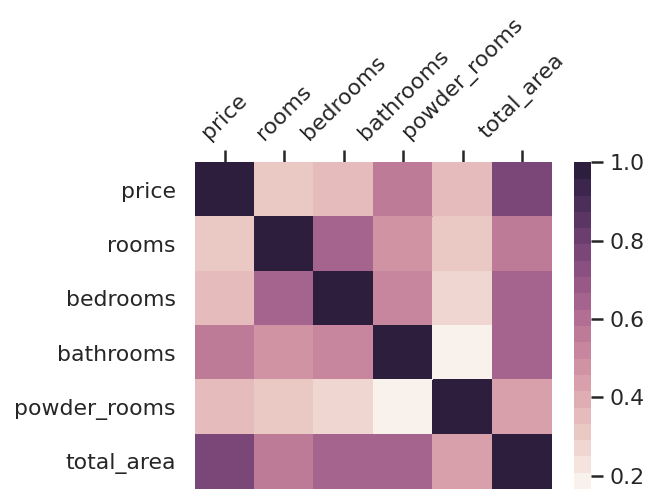

In [58]:
# Configure plot
%config InlineBackend.figure_format='retina'
sns.set()
plt.rcParams['figure.figsize'] = (4, 3) # size in inches 
plt.rcParams['axes.labelpad'] = 10
sns.set_style('darkgrid')

# Correlation heatmap
ax = sns.heatmap(rooms_and_price.corr(), cmap=sns.cubehelix_palette(20, light=0.95, dark=0.15))
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Save fig
plt.savefig('figures/total_area_corr_matrix.png', bbox_inches='tight', dpi=300)

From the heatmap we can see that `price` correlates best with `total_area`, followed by `bedrooms` and `bathrooms`.

In [59]:
# imports for regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
lin_mod_price = LinearRegression()
lin_mod_no_price = LinearRegression()

In [60]:
# Model including price
X = rooms_and_price.loc[:, : 'powder_rooms']
y = rooms_and_price["total_area"]
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X, y, test_size = 0.2, random_state=42)
# Fit model to training data 
lin_mod_price.fit(X_train_price, y_train_price)

# Model without price
X = rooms.loc[:, : 'powder_rooms']
y = rooms["total_area"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
# Fit model to training data 
lin_mod_no_price.fit(X_train, y_train)

LinearRegression()

In [61]:
# Predict test sample with price
pred_price = lin_mod_price.predict(X_test_price)
# RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_price, pred_price))
# R2
test_r2 = r2_score(y_test_price, pred_price)
print("Model with price:")
print("RMSE:", test_rmse)
print("R2:", test_r2)

# Predict test sample without price
pred = lin_mod_no_price.predict(X_test)
# RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, pred))
# R2
test_r2 = r2_score(y_test, pred)
print("\nModel without price:")
print("RMSE:", test_rmse)
print("R2:", test_r2)

Model with price:
RMSE: 300.9966499011587
R2: 0.7887043821912865

Model without price:
RMSE: 390.23910062458515
R2: 0.6448361702696629


Including price gives a significant boost to the fit of the model, but the model without price still performs relatively well.

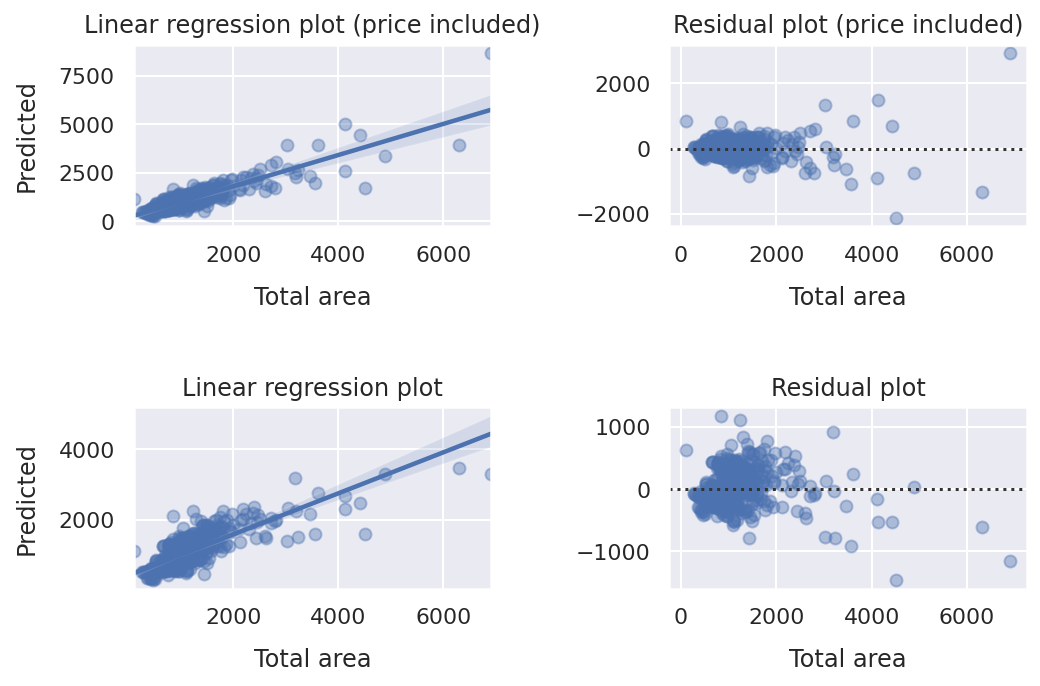

In [62]:
# Configure plot size
plt.rcParams['figure.figsize'] = (8, 5) # size in inches 
# Regression and residual plots
fig, ax = plt.subplots(2,2)
plt.subplots_adjust(wspace=0.5, hspace=1)
# Model with price data 
sns.regplot(y_test_price, pred_price, ax=ax[0, 0], scatter_kws={'alpha':0.4})
sns.residplot(y_test_price, pred_price, ax=ax[0, 1], scatter_kws={'alpha':0.4})
# Model without price data 
sns.regplot(y_test, pred, ax=ax[1, 0], scatter_kws={'alpha':0.4})
sns.residplot(y_test, pred, ax=ax[1, 1], scatter_kws={'alpha':0.4})
# Axis parameters
ax[0, 0].set(title='Linear regression plot (price included)', ylabel="Predicted", xlabel="Total area")
ax[0, 1].set(title='Residual plot (price included)', xlabel="Total area")
ax[1, 0].set(title='Linear regression plot', ylabel="Predicted", xlabel="Total area")
ax[1, 1].set(title='Residual plot', xlabel="Total area")
plt.savefig('figures/total_area_prediction.png', bbox_inches='tight', dpi=300)

The model is best suited for total areas below 4000 sqft but performs quite well in general. It seems unlikely that removing outliers will have a significant improvement on either model. We will next brake down further contrast the peroformance of the two models.

In [63]:
replace_df = df[df.total_area <= 1]
with_price = replace_df.loc[:,\
        ['price', 'rooms',\
        'bedrooms','bathrooms',\
        'powder_rooms']\
            ]

without_price = replace_df.loc[:,\
        ['rooms',\
        'bedrooms','bathrooms',\
        'powder_rooms']\
            ]

In [64]:
replacement_from_price = lin_mod_price.predict(with_price)
replacement_without_price = lin_mod_no_price.predict(without_price)

In [65]:
# Replace with model based on room data and price
new_total_area = df.total_area.copy()
new_total_area[new_total_area <= 1] = replacement_from_price
df["new_area_from_price"] = new_total_area

# Replace with model based on room data only
new_total_area = df.total_area.copy()
new_total_area[new_total_area <= 1] = replacement_without_price
df["new_area_from_rooms"] = new_total_area

In [66]:
# Subsection of price and new area columns
compair = df.loc[:, ["price", "new_area_from_price", "new_area_from_rooms"]]
compair[df.total_area <= 1]

,price,new_area_from_price,new_area_from_rooms
5,698000,1537.141985,1899.934662
7,1725000,2016.260110,1931.265462
8,619000,1846.636849,2229.642812
9,679000,1490.779393,1868.603863
10,569750,655.611199,556.062868
...,...,...,...
5307,2399000,3239.640220,3087.983888
5309,11900000,8212.588474,4752.944423
5311,1949000,2626.623579,2695.614140
5312,3600000,3609.940026,3196.075503


2050 values have been replace in `total_area`


In [67]:
# Correlation of values that were not imputed
compair.corr()[['price']]

,price
price,1.000000
new_area_from_price,0.789416
new_area_from_rooms,0.614602


In [68]:
 # Correlation of imputed values only
 compair[df.total_area <= 1].corr()[["price"]]

,price
price,1.000000
new_area_from_price,0.817373
new_area_from_rooms,0.474608


From the above comparison we can see that the model based on only rooms performs significantly worse when correlating only the imputed records, whereas the model that included price performs better. To some extent this was expected since we engineered a correlation into the imputed values.  

But this striking differential leads to suggest that condos don't exhibit the same trends and correlation as other housing types. Consequently, we will focus on condos and loft for the rest of the analysis, which make up the majority of the data.

In [69]:
# Condos only
condos = df[total_area > 1].copy()
condos.reset_index(drop=True, inplace=True)
condos.title.value_counts()

Condo for sale            3222
Loft / Studio for sale      47
Name: title, dtype: int64

### Missing: additional_features

In [70]:
# Columns with less than 3100 values
less_than_3100 = condos.apply(lambda col: col.notnull().sum() < 3100, axis=0)
condos.loc[:, less_than_3100].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269 entries, 0 to 3268
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   parking_(total)                    1992 non-null   object
 1   pool                               1107 non-null   object
 2   additional_features                1785 non-null   object
 3   building_style                     0 non-null      object
 4   lot_area                           0 non-null      object
 5   fireplace/stove                    288 non-null    object
 6   in_basement                        199 non-null    object
 7   use_of_property                    0 non-null      object
 8   number_of_units                    0 non-null      object
 9   residential_units                  0 non-null      object
 10  potential_gross_revenue            0 non-null      object
 11  intergenerational                  0 non-null      object
 12  buildi

In [71]:
condos.additional_features[condos.additional_features.notnull()].value_counts()[:15]

Elevator                                                                                        870
Adapted for reduced mobility, Elevator                                                          504
Basement 6 feet or +                                                                            118
Located on a fleuve (river), Elevator                                                            34
Located on a fleuve (river), Adapted for reduced mobility, Elevator                              27
Basement 6 feet or +, Elevator                                                                   25
Elevator, EV charging station                                                                    19
Adapted for reduced mobility                                                                     19
Located on a fleuve (river), Navigable body of water, Adapted for reduced mobility, Elevator     15
Located on a canal, Elevator                                                                     15


From this, the most valuable information might be proximity to the river. We will check how many values correspond to this.

In [72]:
river_proximity = condos.additional_features.apply(lambda x: re.search("[Rr]iver", str(x)))
river_proximity = pd.Series(river_proximity).astype("bool")
river_proximity.rename("river_prox", inplace=True)
print("Listings with proximity to river:", river_proximity.sum())
# River proximity and price
river_and_price = pd.concat([river_proximity, condos.price], axis=1)
print("\nRiver-price correlation all records:")
river_and_price.corr()

Listings with proximity to river: 134

River-price correlation all records:


,river_prox,price
river_prox,1.000000,0.052568
price,0.052568,1.000000


In [73]:
river_and_price.corr(method="spearman")

,river_prox,price
river_prox,1.000000,0.122587
price,0.122587,1.000000


The data is too unbalanced with too little of a correlation with price to be useful in a linear regression. We will next create a balanced subset and reevaluate its correlation with price.

In [74]:
def generate_50_50_slice(first_half, data):
    """Returns a data frame of elements found in "first_half" suplemented with a random
    collection of elements from "data" of the same length as "first_half". 
    
    Args:
    first_half : Series object of elementsS found in "data"
    data : Series object from which the remaining elements are drawn
    
    Returns:
    merge : data frame that contains firs_half and records of equal number selected 
        at random from "data"
    """
    # Random records without river proximity of equal length to "river_proximity"
    remainder = pd.DataFrame()
    count = 0
    index = 0
    while count <= len(first_half):
        # New index to create random subset   
        index = random.choice(data.index)
        # Only elements found neither in firs_half nor remainder
        if index not in first_half.index\
            and index not in remainder.index:
            # New record to append
            column_name = first_half.name
            value = data.iloc[index]
            new_record = pd.DataFrame({0: value}, index=[index])
            #Append
            remainder = pd.concat([remainder, new_record])
            count += 1
    # Merge dataframes 
    merge = pd.concat([first_half, remainder])
    merge.columns = [column_name]
    return merge

# Only records with river proximity
proximity = river_proximity[river_proximity == True]
# 50:50 slice of "river proximity"/"no river proximity"
prox = generate_50_50_slice(proximity, river_proximity)
mat = pd.concat([prox, condos.loc[prox.index, "price"]], axis=1)

# Correlation of river proximity with price 
print("\nRiver-price correlation with random 50:50 sub-set (Pearson)")
mat.corr()


River-price correlation with random 50:50 sub-set (Pearson)


,river_prox,price
river_prox,1.000000,0.254966
price,0.254966,1.000000


In [75]:
print("\nRiver-price correlation with random 50:50 sub-set (Spearman)")
mat.corr(method="spearman")


River-price correlation with random 50:50 sub-set (Spearman)


,river_prox,price
river_prox,1.000000,0.306301
price,0.306301,1.000000


The correlation is still low but more interesting, we will keep the information as a seperate categorical feature for other potential models.

In [76]:
# Add river_poximity feature
condos["river_proximity"] = river_proximity
condos.drop("additional_features", axis=1, inplace=True)
condos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269 entries, 0 to 3268
Data columns (total 90 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   index                                    3269 non-null   int64  
 1   title                                    3269 non-null   object 
 2   address                                  3269 non-null   object 
 3   price                                    3269 non-null   int64  
 4   lat                                      3269 non-null   float64
 5   long                                     3269 non-null   float64
 6   restaurants                              3263 non-null   float64
 7   shopping                                 3265 non-null   float64
 8   vibrant                                  3264 non-null   float64
 9   cycling_friendly                         3263 non-null   float64
 10  car_friendly                             3262 no

Next we will remove some irrelevant seeming features with very high numbers of missing records for condos.

In [77]:
# Remove columns with less than 700 records 
condos.dropna("columns", thresh=700, inplace=True)

# Slice containing 1+ missing values
condos.loc[:, condos.notnull().sum() < 3269].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269 entries, 0 to 3268
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   restaurants          3263 non-null   float64
 1   shopping             3265 non-null   float64
 2   vibrant              3264 non-null   float64
 3   cycling_friendly     3263 non-null   float64
 4   car_friendly         3262 non-null   float64
 5   historic             3258 non-null   float64
 6   quiet                3256 non-null   float64
 7   elementary_schools   3266 non-null   float64
 8   high_schools         3265 non-null   float64
 9   nightlife            3261 non-null   float64
 10  groceries            3267 non-null   float64
 11  daycares             3265 non-null   float64
 12  pedestrian_friendly  3267 non-null   float64
 13  cafes                3264 non-null   float64
 14  transit_friendly     3268 non-null   float64
 15  greenery             3260 non-null   f

### Missing: pool records

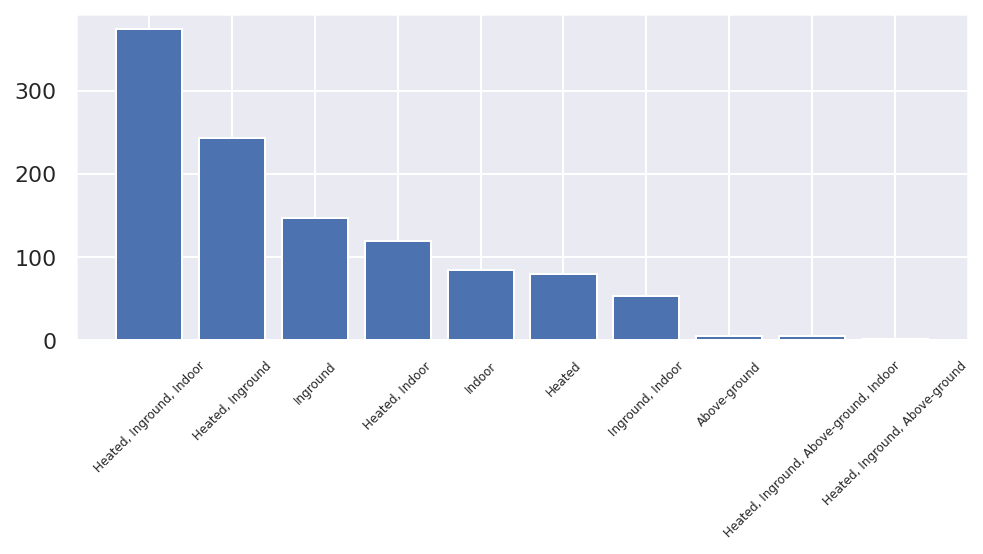

In [78]:
# Count of different pool types
plt.figure(figsize=(8,3))
plt.bar(condos.pool.value_counts().index,\
        condos.pool.value_counts().values)

plt.xticks(rotation=45, fontsize=6)
plt.show()

In [79]:
# boolean pool records (has pool/no pool) correlation to price
has_pool = condos.pool.notnull()
pool_and_price = pd.concat([has_pool, condos.price], axis=1)
pool_and_price.columns = ["has_pool", "price"]
# Pearson
pool_and_price.corr()

,has_pool,price
has_pool,1.000000,0.192002
price,0.192002,1.000000


In [80]:
# Spearman
pool_and_price.corr(method='spearman')

,has_pool,price
has_pool,1.000000,0.257394
price,0.257394,1.000000


<AxesSubplot:xlabel='has_pool', ylabel='log_price'>

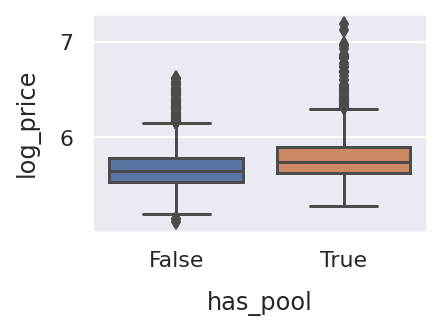

In [81]:
# boxplot of has_pool to log transformed price
plt.figure(figsize=(3,2))
pool_and_price["log_price"] = pool_and_price.price.transform(np.log10)
sns.boxplot(data=pool_and_price, x="has_pool", y="log_price")

The relationship seems not particularly strong but we will keep a feature of the boolean values just in case.

In [82]:
# Has pool
condos['has_pool'] = has_pool
# Drop old pool feature
condos.drop("pool", axis=1, inplace=True)

# Slice containing 1+ missing values
condos.loc[:, condos.notnull().sum() < 3269].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269 entries, 0 to 3268
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   restaurants          3263 non-null   float64
 1   shopping             3265 non-null   float64
 2   vibrant              3264 non-null   float64
 3   cycling_friendly     3263 non-null   float64
 4   car_friendly         3262 non-null   float64
 5   historic             3258 non-null   float64
 6   quiet                3256 non-null   float64
 7   elementary_schools   3266 non-null   float64
 8   high_schools         3265 non-null   float64
 9   nightlife            3261 non-null   float64
 10  groceries            3267 non-null   float64
 11  daycares             3265 non-null   float64
 12  pedestrian_friendly  3267 non-null   float64
 13  cafes                3264 non-null   float64
 14  transit_friendly     3268 non-null   float64
 15  greenery             3260 non-null   f

## Missing: parking records

In [83]:
condos["parking_(total)"].value_counts()

Garage (1)                  1293
Garage (2)                   295
Driveway (1)                 275
Driveway (1), Garage (1)      46
Garage (3)                    22
Driveway (2)                  16
Garage (4)                     9
Carport (1)                    6
Driveway (1), Garage (2)       5
Garage (5)                     3
Driveway (2), Garage (1)       2
Garage (24)                    2
Garage (117)                   1
Driveway (3)                   1
Driveway (33)                  1
Garage (37)                    1
Carport (26), Garage (1)       1
Garage (277)                   1
Garage (17)                    1
Garage (52)                    1
Garage (70)                    1
Driveway (120)                 1
Carport (1), Garage (1)        1
Driveway (4), Garage (2)       1
Carport (2)                    1
Driveway (3), Garage (1)       1
Garage (263)                   1
Garage (81)                    1
Garage (29)                    1
Garage (26)                    1
Name: park

First, we will need to transform this to a numeric feature. Either indicating the number of available parkings or a boolean feature for whether parking is available.

In [84]:
def get_n_parking(row):
    """
    Extracts the numbers of available parking spots
    regardless of parking type.
    """
    try:
        parking = re.findall("\d+", row)
    except:
        parking = [0]
    n_parking = 0
    for n in parking:
        n_parking += float(n)
    return n_parking

condos["n_parking"] = condos["parking_(total)"].apply(lambda row: get_n_parking(row))

In [85]:
pd.concat([condos.price, condos.n_parking], axis=1).corr()

,price,n_parking
price,1.000000,0.022033
n_parking,0.022033,1.000000


In [86]:
# 50:50 correlation of the number of available parking and price
parking = condos.n_parking.copy()
parking_50_50 = generate_50_50_slice(parking[parking == True], parking)
# Add price to corresponding records
parking_and_price = pd.concat([parking_50_50, condos.loc[parking_50_50.index, "price"]], axis=1)
# Pearson
parking_and_price.corr()

,n_parking,price
n_parking,1.000000,0.028389
price,0.028389,1.000000


In [87]:
# Spearman
parking_and_price.corr(method='spearman')

,n_parking,price
n_parking,1.000000,0.324101
price,0.324101,1.000000


In [88]:
# Outliers 
print("Count of number of parking spots:")
parking_and_price[["n_parking"]].value_counts().head(10)

Count of number of parking spots:


n_parking
1.0          1574
0.0          1198
2.0           327
3.0            23
4.0             9
5.0             3
24.0            2
120.0           1
6.0             1
17.0            1
dtype: int64

In [89]:
correlations = {}
# Coefficients after removing number of parkings larger than n
for n in range(30):
    removed_outliers = parking_and_price[parking_and_price["n_parking"] < n]
    park_price_corr = removed_outliers.corr().iloc[1,0]
    correlations[n] = park_price_corr
correlations

{0: nan,
 1: nan,
 2: 0.05028435898872788,
 3: 0.2705759534410254,
 4: 0.29802962849721487,
 5: 0.32141808311522624,
 6: 0.33534483563458317,
 7: 0.33184133220416917,
 8: 0.33184133220416917,
 9: 0.33184133220416917,
 10: 0.33184133220416917,
 11: 0.33184133220416917,
 12: 0.33184133220416917,
 13: 0.33184133220416917,
 14: 0.33184133220416917,
 15: 0.33184133220416917,
 16: 0.33184133220416917,
 17: 0.33184133220416917,
 18: 0.3039509434885756,
 19: 0.3039509434885756,
 20: 0.3039509434885756,
 21: 0.3039509434885756,
 22: 0.3039509434885756,
 23: 0.3039509434885756,
 24: 0.3039509434885756,
 25: 0.23792532736352157,
 26: 0.23792532736352157,
 27: 0.21325088366306502,
 28: 0.19262943806157157,
 29: 0.19262943806157157}

Correlation is highest after removing parkings with numbers above 6. We will therefore transform any values above 6 into 6 as the maximum number of available parking spots and reevaluate the correlation

In [90]:
# Correlation after assigning value of 6 to outliers
parking_and_price[parking_and_price["n_parking"] > 6] = 6
parking_and_price.corr()

,n_parking,price
n_parking,1.000000,0.271317
price,0.271317,1.000000


Text(0.5, 0, 'Number of parking spots')

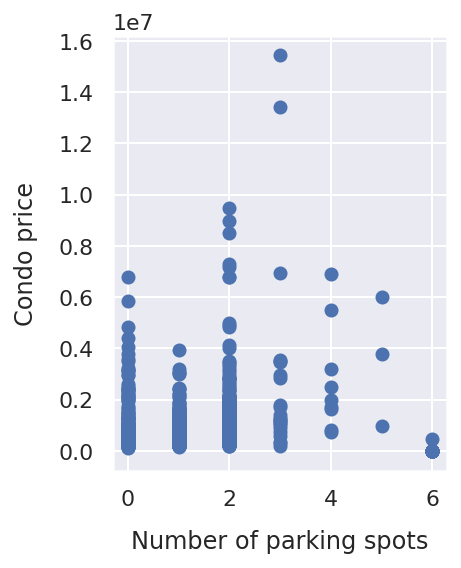

In [91]:
# Plot of price vs. number of parking spots
plt.figure(figsize=(3,4))
plt.scatter(parking_and_price["n_parking"], parking_and_price.price)
plt.ylabel('Condo price')
plt.xlabel('Number of parking spots')

From the figure we can see that values assigned to 6 parking spots have low prices condo prices associated with them. Better results would be achieved by either deleting the values or assigning them to 0. We will next assess correlation of a boolean parking features.

In [92]:
# Boolean has parking feature
parking_and_price["has_parking"] = parking_and_price.n_parking.apply(lambda row: row != 0)
parking_and_price.corr(method='spearman')[['price']]

,price
n_parking,0.310600
price,1.000000
has_parking,0.239641


Lastly we will extract a boolean feature that indicates available garage parking only since this would be expected to have the largest effect on the price of a condo. Driveway parking is usually not included in the buying price.

In [93]:
has_garage = condos["parking_(total)"].apply(lambda row: "Garage" in str(row)) # convert np.nan to string
parking_and_price["has_garage"] = has_garage
parking_and_price.corr(method='spearman')[['price']]

,price
n_parking,0.310600
price,1.000000
has_parking,0.239641
has_garage,0.323374


From this we can tell that the best results are achieved by focusing on available garage spots only which also makes sense. We will therefore chose this feature for further analysis.

In [94]:
condos["has_garage"] = parking_and_price["has_garage"]
condos.drop("parking_(total)", axis=1, inplace=True)

# Slice containing 1+ missing values
condos.loc[:, condos.notnull().sum() < 3269].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269 entries, 0 to 3268
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   restaurants          3263 non-null   float64
 1   shopping             3265 non-null   float64
 2   vibrant              3264 non-null   float64
 3   cycling_friendly     3263 non-null   float64
 4   car_friendly         3262 non-null   float64
 5   historic             3258 non-null   float64
 6   quiet                3256 non-null   float64
 7   elementary_schools   3266 non-null   float64
 8   high_schools         3265 non-null   float64
 9   nightlife            3261 non-null   float64
 10  groceries            3267 non-null   float64
 11  daycares             3265 non-null   float64
 12  pedestrian_friendly  3267 non-null   float64
 13  cafes                3264 non-null   float64
 14  transit_friendly     3268 non-null   float64
 15  greenery             3260 non-null   f

No, we still need to deal with missing values which have been ignored by the transformation.

In [95]:
# Missing parking data
print("Records missing:", condos.has_garage.isnull().sum())
condos[condos.has_garage.isnull()].tail()

Records missing: 120


,index,title,address,price,lat,long,restaurants,shopping,vibrant,cycling_friendly,...,basement_bedroom,bathrooms,powder_rooms,total_area,new_area_from_price,new_area_from_rooms,river_proximity,has_pool,n_parking,has_garage
3088,5149,Condo for sale,"1030, Rue De Bleury, apt. PH15, Montréal (Vill...",3399000,45.503981,-73.562551,10.0,10.0,10.0,5.0,...,False,3.0,1.0,2615.0,2615.0,2615.0,False,True,2.0,NaN
3103,5164,Condo for sale,"1220, Rue Crescent, apt. 903, Montréal (Ville-...",449900,45.496505,-73.574928,10.0,10.0,10.0,4.0,...,False,1.0,0.0,590.0,590.0,590.0,False,False,0.0,NaN
3132,5202,Condo for sale,"650, Rue Notre-Dame Ouest, apt. 1602, Montréal...",2195000,45.500456,-73.559638,10.0,10.0,10.0,7.0,...,False,2.0,1.0,2450.0,2450.0,2450.0,False,True,2.0,NaN
3148,5240,Condo for sale,"1100, Rue de la Montagne, apt. 1801-06, Montré...",2979000,45.496748,-73.573260,10.0,10.0,10.0,4.0,...,False,3.0,0.0,3100.0,3100.0,3100.0,False,True,4.0,NaN
3223,5351,Condo for sale,"1000, Rue de la Commune Est, apt. PH-4-924, Mo...",5499999,45.511978,-73.549533,10.0,10.0,10.0,8.0,...,False,3.0,2.0,4209.0,4209.0,4209.0,False,True,3.0,NaN


It seems like there are several listings at the address `303, boulevard Saint-Joseph`. We will inspect if the data on parking is consistent for all of them.

In [96]:
condos[condos.address.apply(lambda row: "303, boulevard Saint-Joseph" in row)].has_garage

2643    False
2670    False
2671    False
2672      NaN
2673    False
2674    False
2675      NaN
2676    False
2678    False
3197    False
3198    False
3199    False
3200    False
3201    False
3202    False
3203    False
3204    False
3205    False
3206    False
3207    False
3208    False
3209    False
3210    False
3211    False
3212    False
3213    False
3214    False
3215    False
3216    False
3217    False
3218    False
3219    False
Name: has_garage, dtype: object

All parking records for the same address are either false or missing. This suggests that missing values correspond to listings without available parking. We will therefore transform missing values into False by simply changeing the type of the feature to boolean.

In [97]:
condos.has_garage = condos.has_garage.astype('bool')

# Slice containing 1+ missing values
condos.loc[:, condos.notnull().sum() < 3269].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269 entries, 0 to 3268
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   restaurants          3263 non-null   float64
 1   shopping             3265 non-null   float64
 2   vibrant              3264 non-null   float64
 3   cycling_friendly     3263 non-null   float64
 4   car_friendly         3262 non-null   float64
 5   historic             3258 non-null   float64
 6   quiet                3256 non-null   float64
 7   elementary_schools   3266 non-null   float64
 8   high_schools         3265 non-null   float64
 9   nightlife            3261 non-null   float64
 10  groceries            3267 non-null   float64
 11  daycares             3265 non-null   float64
 12  pedestrian_friendly  3267 non-null   float64
 13  cafes                3264 non-null   float64
 14  transit_friendly     3268 non-null   float64
 15  greenery             3260 non-null   f

### Missing: walk_score records

In [98]:
missing_score = condos[condos.walk_score.isnull()]
missing_score

,index,title,address,price,lat,long,restaurants,shopping,vibrant,cycling_friendly,...,basement_bedroom,bathrooms,powder_rooms,total_area,new_area_from_price,new_area_from_rooms,river_proximity,has_pool,n_parking,has_garage
0,0,Condo for sale,"5050, Rue Bannantyne, apt. 203, Montréal (Verd...",409000,45.456079,-73.575949,7.0,8.0,5.0,9.0,...,False,1.0,0.0,1014.0,1014.0,1014.0,False,False,1.0,True
1,1,Condo for sale,"201, Chemin de la Pointe-Sud, apt. 216, Montré...",680000,45.449347,-73.553327,3.0,3.0,1.0,7.0,...,False,2.0,0.0,1249.0,1249.0,1249.0,False,True,2.0,True
9,15,Condo for sale,"240, Rue Lyette, apt. 304, Montréal (LaSalle)",324000,45.430631,-73.665644,5.0,5.0,3.0,8.0,...,False,1.0,0.0,861.0,861.0,861.0,False,False,1.0,True
11,17,Condo for sale,"240, Rue Lyette, apt. 302, Montréal (LaSalle)",324000,45.430631,-73.665644,5.0,5.0,3.0,8.0,...,False,1.0,0.0,871.0,871.0,871.0,False,False,1.0,True
17,30,Condo for sale,"299, Rue de la Rotonde, apt. 204, Montréal (Ve...",528000,45.473050,-73.538448,6.0,5.0,3.0,5.0,...,False,1.0,1.0,1043.0,1043.0,1043.0,True,True,1.0,True
33,56,Condo for sale,"6300, Place Northcrest, apt. 6D, Montréal (Côt...",1459000,45.512260,-73.622631,9.0,10.0,5.0,5.0,...,False,2.0,0.0,2121.0,2121.0,2121.0,False,True,2.0,True
36,61,Condo for sale,"6644, Avenue Somerled, apt. 403, Montréal (Côt...",330000,45.465814,-73.639518,7.0,7.0,5.0,7.0,...,False,1.0,1.0,794.0,794.0,794.0,False,False,1.0,True
42,70,Condo for sale,"4721, Rue Rivard, Montréal (Le Plateau-Mont-Ro...",499000,45.525829,-73.584964,10.0,10.0,10.0,10.0,...,False,1.0,1.0,1086.0,1086.0,1086.0,False,False,0.0,False
521,848,Condo for sale,"12416, Rue Trefflé-Berthiaume, Montréal (Riviè...",329000,45.673748,-73.532910,2.0,2.0,0.0,5.0,...,False,1.0,0.0,1189.0,1189.0,1189.0,False,False,1.0,True
947,1506,Condo for sale,"12459, Rue Trefflé-Berthiaume, Montréal (Riviè...",229000,45.674380,-73.533376,2.0,2.0,0.0,5.0,...,False,1.0,0.0,875.0,875.0,875.0,False,False,1.0,False


In [99]:
# Records with address: "201, Chemin de la Pointe-Sud"
condos[condos.address.apply(lambda row: "201, Chemin de la Pointe-Sud, " in row)].walk_score


1        NaN
1154    11.0
1821    11.0
2050    11.0
2230    14.0
Name: walk_score, dtype: float64

As we can see, the walk score has been omitted for only one of the apartments within the same building. We will use this information to replace the missing values.

In [100]:
# Walk score imputation
new_walk_scores = []
for address in missing_score.address:
    print("Original Address:")
    print(address)
    # Address root of record to impute
    address_of_interest = re.search("\d+,[\sa-zA-Z]+", address).group()
    # Walk scores from records with same address as address_of_interest
    replacement_array = condos[condos.address.apply(lambda row: address_of_interest in row)].walk_score
    # Select most common walk score
    replacement = float(stats.mode(replacement_array.values).mode)
    # Most common value is "nan"
    if str(replacement) == "nan":
        print("Mode is nan")
        # Try min instead of mode
        replacement = float(min(replacement_array.values))
        print("Using min instead:", replacement)

    # Exact address either not found or has also missing walk score
    # -> Search for street name instead of exact address
    if replacement_array.isnull().all():
        
        print("Searching for walk score at nearby addresses")
        # Street name
        street_name = re.search("[a-zA-Z\s]+", address).group()
        # Street number 
        street_number = int(re.search("\d+", address).group())

        # Search for street name in entire data frame
        replacement_data = df[df.address.apply(lambda row: street_name in row)]
        # Extract street numbers 
        replacements = replacement_data.address.apply(lambda address: int(re.search("\d+", address).group()))
        # Tuple of street number differences and corresponding street number 
        replacements_diff = [(np.absolute(replacement - street_number), replacement)\
            for replacement in replacements\
            if np.absolute(replacement - street_number) > 0]
        replacements_diff.sort()

        replacement_found = False
        # If minimum difference in street number small
        for diff in replacements_diff:
            if diff[0] < 200:
                # replacement_address = str(diff[1]) + "," + street_name
                replacement_address = replacement_data[\
                    replacement_data.address.apply(\
                    lambda row: str(diff[1]) in row)]\
                    .address.values[0]
                print("Street number difference:", str(diff[0]))
                print("Walk score at street number", street_number, "replaced by walk score found at number", diff[1])
                replacement = float(df[df.address.apply(lambda row: replacement_address in row)].walk_score)
                
                # Replacement not nan
                if str(replacement) != "nan":
                    break
                else:
                    print("No replacement found!")
            else:
                print("Minimum street number difference too large:", diff[0])
                replacement = np.nan
                break
    print("Replacement:", replacement)
    print("-" * 75)
    new_walk_scores.append(replacement)

Original Address:
5050, Rue Bannantyne, apt. 203, Montréal (Verdun/Île-des-Soeurs), Neighbourhood Verdun
Mode is nan
Using min instead: nan
Searching for walk score at nearby addresses
Street number difference: 110
Walk score at street number 5050 replaced by walk score found at number 4940
Replacement: 80.0
---------------------------------------------------------------------------
Original Address:
201, Chemin de la Pointe-Sud, apt. 216, Montréal (Verdun/Île-des-Soeurs), Neighbourhood Île-des-Soeurs
Replacement: 11.0
---------------------------------------------------------------------------
Original Address:
240, Rue Lyette, apt. 304, Montréal (LaSalle)
Replacement: 31.0
---------------------------------------------------------------------------
Original Address:
240, Rue Lyette, apt. 302, Montréal (LaSalle)
Replacement: 31.0
---------------------------------------------------------------------------
Original Address:
299, Rue de la Rotonde, apt. 204, Montréal (Verdun/Île-des-Soeurs

In [101]:
new_walk_scores = pd.Series(new_walk_scores)
# Adjust indices to missing records
new_walk_scores.index = condos[condos.walk_score.isnull()].index
new_walk_scores

0      80.0
1      11.0
9      31.0
11     31.0
17     35.0
33     55.0
36      NaN
42     95.0
521     NaN
947     NaN
dtype: float64

3 values couldn't be replaced. We will keep them for now but might remove them entirely later.

In [102]:
# Replace
condos.loc[condos.walk_score.isnull(), "walk_score"] = new_walk_scores

# Slice containing 1+ missing values
condos.loc[:, condos.notnull().sum() < 3269].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269 entries, 0 to 3268
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   restaurants          3263 non-null   float64
 1   shopping             3265 non-null   float64
 2   vibrant              3264 non-null   float64
 3   cycling_friendly     3263 non-null   float64
 4   car_friendly         3262 non-null   float64
 5   historic             3258 non-null   float64
 6   quiet                3256 non-null   float64
 7   elementary_schools   3266 non-null   float64
 8   high_schools         3265 non-null   float64
 9   nightlife            3261 non-null   float64
 10  groceries            3267 non-null   float64
 11  daycares             3265 non-null   float64
 12  pedestrian_friendly  3267 non-null   float64
 13  cafes                3264 non-null   float64
 14  transit_friendly     3268 non-null   float64
 15  greenery             3260 non-null   f

The remaining missing values are all neighbourhood indicators. We will inspect listings on centris to evaluate how we can replace records. Should there be no discernible indication on how to proceed, we will simply delete the missing records, since there are only a few left.  

### Missing: Neighbourhood indicators

In [103]:
condos_final = condos.dropna(axis=0)
condos_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3248 entries, 0 to 3268
Data columns (total 78 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   index                                    3248 non-null   int64  
 1   title                                    3248 non-null   object 
 2   address                                  3248 non-null   object 
 3   price                                    3248 non-null   int64  
 4   lat                                      3248 non-null   float64
 5   long                                     3248 non-null   float64
 6   restaurants                              3248 non-null   float64
 7   shopping                                 3248 non-null   float64
 8   vibrant                                  3248 non-null   float64
 9   cycling_friendly                         3248 non-null   float64
 10  car_friendly                             3248 no

### Condominium type

In [104]:
 condos_final.condominium_type.value_counts()

Divided      2964
Undivided     284
Name: condominium_type, dtype: int64

In [105]:
condos_final["is_devided"] =\
    condos_final.condominium_type.apply(lambda x: 1 if x == "Divided" else 0)

In [106]:
condos_final.drop("condominium_type", axis=1, inplace=True)
condos_final.is_devided.value_counts()

1    2964
0     284
Name: is_devided, dtype: int64

In [107]:
# temporary table for correlation
df_corr = condos_final[["is_devided", "price"]]
df_corr.corr(method="spearman")

,is_devided,price
is_devided,1.000000,-0.036215
price,-0.036215,1.000000


Due to the low correlation with price we will drop the feature

In [108]:
condos_final.drop("is_devided", axis=1, inplace=True)
condos_final.reset_index(drop=True)

,index,title,address,price,lat,long,restaurants,shopping,vibrant,cycling_friendly,...,basement_bedroom,bathrooms,powder_rooms,total_area,new_area_from_price,new_area_from_rooms,river_proximity,has_pool,n_parking,has_garage
0,0,Condo for sale,"5050, Rue Bannantyne, apt. 203, Montréal (Verd...",409000,45.456079,-73.575949,7.0,8.0,5.0,9.0,...,False,1.0,0.0,1014.0,1014.0,1014.0,False,False,1.0,True
1,1,Condo for sale,"201, Chemin de la Pointe-Sud, apt. 216, Montré...",680000,45.449347,-73.553327,3.0,3.0,1.0,7.0,...,False,2.0,0.0,1249.0,1249.0,1249.0,False,True,2.0,True
2,2,Condo for sale,"8800, Rue Verville, apt. 101, Montréal (Ahunts...",283000,45.536589,-73.646590,8.0,10.0,5.0,3.0,...,False,1.0,0.0,848.0,848.0,848.0,False,False,1.0,True
3,3,Condo for sale,"185, Rue du Séminaire, apt. 605, Montréal (Le ...",339000,45.490915,-73.560779,10.0,10.0,9.0,9.0,...,False,1.0,0.0,621.0,621.0,621.0,False,True,0.0,False
4,4,Condo for sale,"7075, Rue Bombardier, apt. 108, Montréal (Anjou)",177800,45.606186,-73.588353,6.0,7.0,3.0,4.0,...,False,1.0,0.0,586.0,586.0,586.0,False,False,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,5417,Condo for sale,"4850, Chemin de la Côte-Saint-Luc, apt. PH2, M...",1450000,45.483519,-73.616499,9.0,9.0,5.0,2.0,...,False,2.0,1.0,2265.0,2265.0,2265.0,False,False,0.0,False
3244,5418,Condo for sale,"4500, Chemin de la Côte-des-Neiges, apt. 701, ...",279000,45.495407,-73.606735,10.0,10.0,5.0,8.0,...,False,1.0,0.0,552.0,552.0,552.0,False,False,1.0,True
3245,5419,Condo for sale,"2301, Rue Saint-Patrick, apt. B509, Montréal (...",599000,45.481674,-73.569046,10.0,10.0,7.0,10.0,...,False,1.0,0.0,808.0,808.0,808.0,False,False,0.0,False
3246,5420,Condo for sale,"2301, Rue Saint-Patrick, apt. B215, Montréal (...",1050000,45.481674,-73.569046,10.0,10.0,7.0,10.0,...,False,2.0,0.0,1390.0,1390.0,1390.0,False,False,2.0,True


### Year Built

In [109]:
condos_final.year_built.value_counts()

To be built, New    247
2019                147
2013                145
2016                141
2014                141
                   ... 
1920, Historic        1
2016, Century         1
1929, Century         1
1873, Historic        1
1861, Historic        1
Name: year_built, Length: 199, dtype: int64

In [110]:
# Additional information on buildings
old_buildings = condos_final.year_built.\
    apply(lambda x: re.search("[a-zA-Z\s]+", x).group() if bool(re.search("[a-zA-Z]+", x)) else 0)
old_buildings.value_counts()

0                     2695
To be built            247
Under construction     102
 New                    62
 Historic               53
Unknown age             45
 Century                27
 Being converted        17
Name: year_built, dtype: int64

With historic buildings, the linear relatoinship between age and value would be expected to be lost. Both very new and very old buildings are expected to exhibit a value increase as result of age. We will therefor test the correlation of the entire age data as well as that of historic buildings removed with price.

In [111]:
year_built = condos_final.year_built.\
    apply(lambda x: re.search("\d+", x).group() if bool(re.search("\d+", x)) else np.nan)  

In [112]:
# Indecies of historic buildings
index_historic = old_buildings[(old_buildings == " Historic") | (old_buildings == " Century")].index

# Age of historic/century condos
historic_ages = year_built[index_historic]
historic_ages.sort_values(ascending=False).head(25)

3174    2018
2689    2016
2085    2015
2877    2015
1535    2015
1545    2015
327     2015
2423    2014
2428    2013
334     2006
1062    2005
1695    2005
2219    2003
223     1999
2680    1999
3187    1999
1824    1995
203     1989
2048    1981
2373    1967
2739    1931
396     1929
3134    1929
151     1929
2340    1929
Name: year_built, dtype: object

It is unclear why several new buildings are labeled as historic. From the list, 1931 seems like a reasonable cutoff.

In [113]:
# Update year_build column
condos_final["year_built"] = year_built.astype("float")
# Remove buildings older than 1931
new_condos = condos_final[condos_final["year_built"] > 1931].copy()
# Older buildings included
all_condo_ages = condos_final.copy()
# Drop missing
new_condos.dropna(axis=0, inplace=True)
all_condo_ages.dropna(axis=0, inplace=True)

In [114]:
new_condos[["price", "year_built"]].corr(method="spearman")

,price,year_built
price,1.000000,0.190398
year_built,0.190398,1.000000


In [115]:
all_condo_ages[["price", "year_built"]].corr(method="spearman")

,price,year_built
price,1.000000,0.037667
year_built,0.037667,1.000000


In [116]:
condos_final["year_built"].isnull().sum()

394

In [117]:
condos_final.dropna(axis=0, inplace=True)

Neither options appear to correlate very well with price.

In [118]:
# Drop missing values
condos_final.dropna(inplace=True)
condos_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2854 entries, 0 to 3268
Data columns (total 77 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   index                                    2854 non-null   int64  
 1   title                                    2854 non-null   object 
 2   address                                  2854 non-null   object 
 3   price                                    2854 non-null   int64  
 4   lat                                      2854 non-null   float64
 5   long                                     2854 non-null   float64
 6   restaurants                              2854 non-null   float64
 7   shopping                                 2854 non-null   float64
 8   vibrant                                  2854 non-null   float64
 9   cycling_friendly                         2854 non-null   float64
 10  car_friendly                             2854 no

### Price outliers

In [119]:
# Price outliers
print(condos_final.price.sort_values(ascending=False).head(10))
print(condos_final.price.sort_values(ascending=False).tail(10))

1465    15435000
1464    13435000
492      9500000
1497     8990000
3181     8500000
3122     7300000
1542     7190000
3036     6950000
1534     6900000
1499     6790000
Name: price, dtype: int64
4       177800
930     175500
1250    175000
202     174000
3129    169000
1110    159000
2848    155000
8       139000
1425    139000
417     129900
Name: price, dtype: int64


In [120]:
# Remove outliers based on previous residual plot in visualizations.ipynb
condos_final = condos_final[condos_final.price < 1200000]
condos_final.reset_index(inplace=True, drop=True)

Model features have been selected after running a linear regression on scaled data. Features with small coefficients have been removed to create the final model data.

In [121]:
# Test features
#  Remove features based on regression coefs
test_cols = ['address', 'lat', 'long', 'price', 'total_area', 'restaurants',
       'vibrant', 'cycling_friendly', 'historic',
       'parks', 'groceries', 'pedestrian_friendly',
       'transit_friendly', 'greenery', 'year_built',
       'unemployment_rate_2016_', 'bathrooms', 
       'powder_rooms', 'river_proximity', 'has_pool', 'has_garage']
condos_test = condos_final[test_cols]
condos_test.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2678 entries, 0 to 2677
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   address                  2678 non-null   object 
 1   lat                      2678 non-null   float64
 2   long                     2678 non-null   float64
 3   price                    2678 non-null   int64  
 4   total_area               2678 non-null   float64
 5   restaurants              2678 non-null   float64
 6   vibrant                  2678 non-null   float64
 7   cycling_friendly         2678 non-null   float64
 8   historic                 2678 non-null   float64
 9   parks                    2678 non-null   int64  
 10  groceries                2678 non-null   float64
 11  pedestrian_friendly      2678 non-null   float64
 12  transit_friendly         2678 non-null   float64
 13  greenery                 2678 non-null   float64
 14  year_built              

In [122]:
# Read final finals to csv
condos_test.to_csv("data/model_data.csv")
condos_final.to_csv("data/condos.csv")